In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn import decomposition

In [2]:
df = pd.read_csv('./data/dataset_cleaned.csv')

# extract all columns except 'goal' --> X
X = df.loc[:, df.columns != 'goal']
# extract only the column 'goal' --> y
y = df.loc[:, 'goal']

# add new axis to y, new shape: (n, 1)
y = y.to_numpy()
y = y.reshape((len(y),1))

# binarize y
y[y>0] = 1

factor_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
numeric_columns = [column for column in X.columns if column not in factor_columns]

# transform factors into onehot vectors
X = pd.get_dummies(X, columns=factor_columns)

# min max scaling of numeric columns
scaler = MinMaxScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

X.head()

age  trestbps      chol   thalach   oldpeak  sex_0  sex_1   cp_1  \
0  0.708333  0.481132  0.244292  0.603053  0.370968  False   True   True   
1  0.791667  0.622642  0.365297  0.282443  0.241935  False   True  False   
2  0.791667  0.245283  0.235160  0.442748  0.419355  False   True  False   
3  0.166667  0.339623  0.283105  0.885496  0.564516  False   True  False   
4  0.250000  0.339623  0.178082  0.770992  0.225806   True  False  False   

    cp_2   cp_3  ...  slope_1  slope_2  slope_3  thal_3.0  thal_6.0  thal_7.0  \
0  False  False  ...    False    False     True     False      True     False   
1  False  False  ...    False     True    False      True     False     False   
2  False  False  ...    False     True    False     False     False      True   
3  False   True  ...    False    False     True      True     False     False   
4   True  False  ...     True    False    False      True     False     False   

   ca_0.0  ca_1.0  ca_2.0  ca_3.0  
0    True   False   False   False  
1   False   False   False    True  
2   False   False    True   False  
3    True   False   False   False  
4    True   False   False   False  

[5 rows x 28 columns]

In [3]:
def get_model(n_features):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(n_features,)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name='test')
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.BinaryCrossentropy())
    return model

In [4]:
import tensorflow as tf

use_pca = True
# number of components extracted from the pca
n_features = 8
n_features = n_features if use_pca else len(X.columns)

epochs = 20
k_folds = 10

# used to split the dataset into k folds
kf = KFold(n_splits=k_folds)

accuracies = []
print(f'Training {k_folds} folds for {epochs} epochs')
for i, (train_idx, test_idx) in enumerate(kf.split(X)):

    print(f'Fold {i}')
    
    # extract train and test data from the cleaned dataset
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f'\tTrain samples:\t{len(X_train)}\tTest samples:\t{len(X_test)}')

    if use_pca:
        # do pca based on the train data of the given fold to extract 'n_features'
        pca = decomposition.PCA(n_components=n_features)
        pca.fit(X_train)
        X_train = pca.transform(X_train)

    # train the model using the components extracted from pca
    model = get_model(n_features)
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    if use_pca:
        # transform test data using on the pca model trained on the train data
        X_test = pca.transform(X_test)
        
    y_pred = model.predict(X_test, verbose=0)
    y_pred = y_pred > 0.5 # threshold to binarize

    # calculate the accuracy of the train data for the current fold
    accuracy = sum(y_pred == y_test)[0] / len(y_pred)
    accuracies.append(accuracy)
    print(f'\tAccuracy: {accuracy:.3%}')

# calculate the average accuracy over all folds
avg_accuracy = sum(accuracies) / len(accuracies)
print(f'Avg accuracy {avg_accuracy:.3%}')

Training 10 folds for 20 epochs
Fold 0
	Train samples:	267	Test samples:	30
	Accuracy: 90.000%
Fold 1
	Train samples:	267	Test samples:	30
	Accuracy: 86.667%
Fold 2
	Train samples:	267	Test samples:	30
	Accuracy: 90.000%
Fold 3
	Train samples:	267	Test samples:	30
	Accuracy: 93.333%
Fold 4
	Train samples:	267	Test samples:	30
	Accuracy: 83.333%
Fold 5
	Train samples:	267	Test samples:	30
	Accuracy: 90.000%
Fold 6
	Train samples:	267	Test samples:	30
	Accuracy: 76.667%
Fold 7
	Train samples:	268	Test samples:	29
	Accuracy: 89.655%
Fold 8
	Train samples:	268	Test samples:	29
	Accuracy: 79.310%
Fold 9
	Train samples:	268	Test samples:	29
	Accuracy: 79.310%
Avg accuracy 85.828%


In [5]:
from sklearn.cluster import KMeans

use_pca = True
# number of components extracted from the pca
n_features = 10

k_folds = 5

# used to split the dataset into k folds
kf = KFold(n_splits=k_folds)

accuracies = []
print(f'Training {k_folds} folds')
for i, (train_idx, test_idx) in enumerate(kf.split(X[numeric_columns])):

    print(f'Fold {i}')
    
    # extract train and test data from the cleaned dataset
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f'\tTrain samples:\t{len(X_train)}\tTest samples:\t{len(X_test)}')

    if use_pca:
        # do pca based on the train data of the given fold to extract 'n_features'
        pca = decomposition.PCA(n_components=n_features)
        pca.fit(X_train)
        X_train = pca.transform(X_train)

    model = KMeans(n_clusters=2, n_init=10)
    model.fit(X_train)

    if use_pca:
        X_test = pca.transform(X_test)
        
    y_pred = model.predict(X_test)

    # calculate the accuracy of the train data for the current fold
    accuracy1 = sum(y_pred == y_test)[0] / len(y_pred)
    accuracy2 = sum(y_pred != y_test)[0] / len(y_pred)
    accuracy = max(accuracy1, accuracy2)
    accuracies.append(accuracy)
    print(f'\tAccuracy {accuracy:.3%}')
    print()

# calculate the average accuracy over all folds
avg_accuracy = sum(accuracies) / len(accuracies)
print(f'Avg accuracy {avg_accuracy:.3%}')

Training 5 folds
Fold 0
	Train samples:	237	Test samples:	60


C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


	Accuracy 58.333%

Fold 1
	Train samples:	237	Test samples:	60


C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


	Accuracy 50.000%

Fold 2
	Train samples:	238	Test samples:	59


C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


	Accuracy 55.932%

Fold 3
	Train samples:	238	Test samples:	59


C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


	Accuracy 57.627%

Fold 4
	Train samples:	238	Test samples:	59


C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


	Accuracy 52.542%

Avg accuracy 54.887%


In [6]:
from sklearn.ensemble import RandomForestClassifier

use_pca = True
# number of components extracted from the pca
n_features = 10

k_folds = 5

# used to split the dataset into k folds
kf = KFold(n_splits=k_folds)

accuracies = []
print(f'Training {k_folds} folds')
for i, (train_idx, test_idx) in enumerate(kf.split(X[numeric_columns])):
    print(f'Fold {i}')

    # extract train and test data from the cleaned dataset
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    y_train, y_test = y_train[:, 0], y_test[:, 0]

    print(f'\tTrain samples:\t{len(X_train)}\tTest samples:\t{len(X_test)}')

    if use_pca:
        # do pca based on the train data of the given fold to extract 'n_features'
        pca = decomposition.PCA(n_components=n_features)
        pca.fit(X_train)
        X_train = pca.transform(X_train)

    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_train, y_train)

    if use_pca:
        X_test = pca.transform(X_test)
        
    y_pred = model.predict(X_test)

    # calculate the accuracy of the train data for the current fold
    accuracy = sum(y_pred == y_test) / len(y_pred)
    accuracies.append(accuracy)
    print(f'\tAccuracy {accuracy:.3%}')
    print()

# calculate the average accuracy over all folds
avg_accuracy = sum(accuracies) / len(accuracies)
print(f'Avg accuracy {avg_accuracy:.3%}')

Training 5 folds
Fold 0
	Train samples:	237	Test samples:	60
	Accuracy 85.000%

Fold 1
	Train samples:	237	Test samples:	60
	Accuracy 90.000%

Fold 2
	Train samples:	238	Test samples:	59
	Accuracy 84.746%

Fold 3
	Train samples:	238	Test samples:	59
	Accuracy 76.271%

Fold 4
	Train samples:	238	Test samples:	59
	Accuracy 77.966%

Avg accuracy 82.797%


### Clustering and PCA
Um zu analysieren, ob ähnliche Merkmale auch zur gleichen Diagnose führen, wird zuerst ein k-Means Clustering angewandt.

In [7]:
# prepare data for clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# prepare model KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans.fit(X)

C:\Users\maxwi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=2, n_init='auto', random_state=42)

In [8]:
# calculate percentage of data points correctly assigned to each cluster
cluster1 = kmeans.labels_ == 0
cluster2 = kmeans.labels_ == 1

perc_cluster1 = np.round(np.mean(cluster1 == y) * 100, decimals=2)
perc_cluster2 = np.round(np.mean(cluster2 == y) * 100, decimals=2)

# choose cluster with higher correspondence
if perc_cluster1 > perc_cluster2:
    km_healthy = cluster1
    max_perc = perc_cluster1
else:
    km_healthy = cluster2
    max_perc = perc_cluster2

print(f"{max_perc}% der Datensätze wurden mithilfe von KMeans richtig einem Cluster zugeordnet")

# hier vlt noch irgendwie diskutieren ob das ein smart way ist um das auszuwerten, anscheinend gibt's dafür andere Metriken

50.2% der Datensätze wurden mithilfe von KMeans richtig einem Cluster zugeordnet


Proportion of variance explained by each principal component:
[2.34198813e-01 1.25628556e-01 1.09931362e-01 8.74811618e-02
 7.82747684e-02 6.31208837e-02 6.24229494e-02 5.34948492e-02
 4.17139647e-02 3.17012077e-02 2.52492654e-02 2.21354486e-02
 1.84895571e-02 1.74748048e-02 8.28895271e-03 5.47222590e-03
 4.87868838e-03 3.91078109e-03 3.44014667e-03 2.69161359e-03
 5.88469272e-33 3.26180402e-33 1.59388562e-33 1.39694325e-33
 1.30446173e-33 1.30446173e-33 1.30446173e-33 1.11776656e-34]


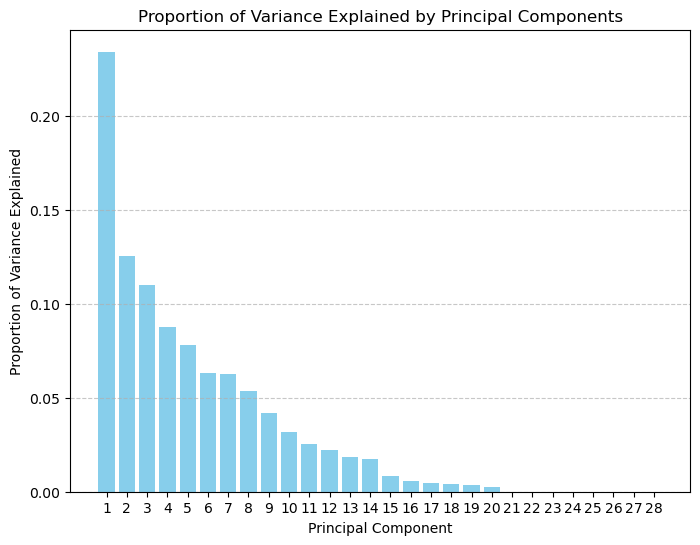

In [9]:
# apply PCA
pca = PCA()
pca.fit(X)

print(f"Proportion of variance explained by each principal component:\n{pca.explained_variance_ratio_}")

# Plot the proportion of variance explained
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Principal Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Interpretation
Eine Hauptkomponente mit einem größeren Anteil der Varianz erklärt mehr Variation in den Daten und ist daher wichtiger für die Reduktion der Dimensionalität. Die Summe aller Anteile der Varianz erklärt die Gesamtvarianz der Daten.  
In diesem spezifischen Fall erklärt die erste Hauptkomponente (PC1) etwa 23.4% der Gesamtvarianz, die zweite Hauptkomponente (PC2) etwa 12.6% usw. Basierend auf diesen Daten kann beurteilt werden, wie viel Varianz jede Hauptkomponente in den Daten erklärt und wie wichtig jede Hauptkomponente für die Repräsentation der Daten ist.

In [10]:
# get the loadings or weights of features in the first principal component
first_pc_loadings = pca.components_[0]

# create a DataFrame to display the contributions of features to the first principal component
pc_loadings_df = pd.DataFrame({"Feature": X.columns, "Contribution": first_pc_loadings})
pc_loadings_df = pc_loadings_df.sort_values(by="Contribution", ascending=False)

print("Contributions of features to the first principal component:")
print(pc_loadings_df)

Contributions of features to the first principal component:
      Feature  Contribution
17    exang_1      0.332492
23   thal_7.0      0.331968
10       cp_4      0.328138
19    slope_2      0.272838
6       sex_1      0.196119
15  restecg_2      0.131840
25     ca_1.0      0.107372
4     oldpeak      0.094386
26     ca_2.0      0.078705
0         age      0.046441
27     ca_3.0      0.046405
22   thal_6.0      0.041738
1    trestbps      0.020995
20    slope_3      0.020165
12      fbs_1      0.013534
2        chol      0.005950
14  restecg_1      0.004777
7        cp_1     -0.009925
11      fbs_0     -0.013534
3     thalach     -0.092913
13  restecg_0     -0.136618
8        cp_2     -0.139917
9        cp_3     -0.178297
5       sex_0     -0.196119
24     ca_0.0     -0.232482
18    slope_1     -0.293003
16    exang_0     -0.332492
21   thal_3.0     -0.373706


#### Interpretation
Die Werte der Spalte "Contribution" zeigen die Stärke des Beitrags jedes Merkmals zur ersten Hauptkomponente. Merkmale mit größeren Beträgen haben eine größere Bedeutung für die erste Hauptkomponente und tragen mehr zur Variation der Daten bei.  
In diesem spezifischen Fall tragen beispielsweise die Merkmale "exang_1", "thal_7.0" und "cp_4" am stärksten zur ersten Hauptkomponente bei, während "thal_3.0", "slope_1" und "exang_0" die stärksten negativen Beiträge haben.
Darauf basierend kann analysiert werden, welche Merkmale die größte Bedeutung für die erste (wichtigste) Hauptkomponente haben und somit die größte Variation in den Daten erklären. Das kann helfen, die wichtigsten Merkmale zu identifizieren, die die gegebenen Datenstrukturen beeinflussen.

Hier würde das bedeuten, dass 'exang_1' (existing exercised induced angina), 'thal_7' (reversable effect caused by thalassemia) und cp_4 (asymptomatic type of chest pain) einen potenziell größeren Einfluss auf die Zielvariable haben, als andere Merkmale.